In [1]:
# FILE READING & PREPROCESSING

#For each file:
#  - Read with actipy
#  - Apply preprocessing

#Segment data into nights (22:00–06:00)

#For each night:
#  - Check non-wear duration → already done by ACTIPY (it flags nonwear periods longer than 60minutes)
#  - Check temperature

#If valid night:
#  - Store x/y/z/timestamps in .h5

In [2]:
import actipy # Actipy expicitly supports .cwa files
import h5py
import pandas as pd
import numpy as np
import datetime
import os

import matplotlib.pyplot as plt

# Parameters
raw_dir = "data/raw"
hdf5_filename = "data/preprocessed/preprocessed_data.h5"

# Gather all CWA files
cwa_files = [os.path.join(raw_dir, f) for f in os.listdir(raw_dir) if f.endswith(".cwa")]
print(f"Found {len(cwa_files)} CWA files.")

Found 1 CWA files.


In [3]:
def segment_by_night(df, start_hour=22, end_hour=6):
    """
    Segments data into separate nights based on a defined sleep window (10 PM - 6 AM).
    This function groups the data by date and extracts only the hours that fall within the sleep window.
    
    Parameters:
    df (pd.DataFrame): The accelerometer data with timestamps as index.
    start_hour (int): The hour at which nighttime starts (default: 22, i.e., 10 PM).
    end_hour (int): The hour at which nighttime ends (default: 6, i.e., 6 AM).
    
    Returns:
    dict: A dictionary where each key is a date, and each value is a DataFrame containing nighttime data.
    """
    df = df.copy()
    df['datetime'] = df.index  # Keep timestamps as a column
    df['date'] = df['datetime'].dt.date  # Extract date
    df['hour'] = df['datetime'].dt.hour  # Extract hour
    
    nights = {}  # Dictionary to store segmented nights

    for date in df['date'].unique():
        # Define two time ranges to capture data that crosses midnight
        night_start = datetime.datetime.combine(date, datetime.time(start_hour, 0, 0))
        next_day = date + datetime.timedelta(days=1)
        night_end = datetime.datetime.combine(next_day, datetime.time(end_hour, 0, 0))

        # Filter data spanning 10 PM to 6 AM (including across midnight)
        night_data = df[(df['datetime'] >= night_start) & (df['datetime'] < night_end)]
        
        if not night_data.empty:
            nights[str(date)] = night_data[['datetime', 'x', 'y', 'z']]
    
    return nights


Processing file 1/1: data/raw/2290025_90001_0_0.cwa
Reading file... Done! (10.11s)
Converting to dataframe... Done! (0.74s)
Quality control... Done! (4.34s)
Lowpass filter... Done! (10.15s)
Gravity calibration... Done! (16.20s)
Nonwear detection... Done! (7.22s)
Resampling... Done! (4.86s)


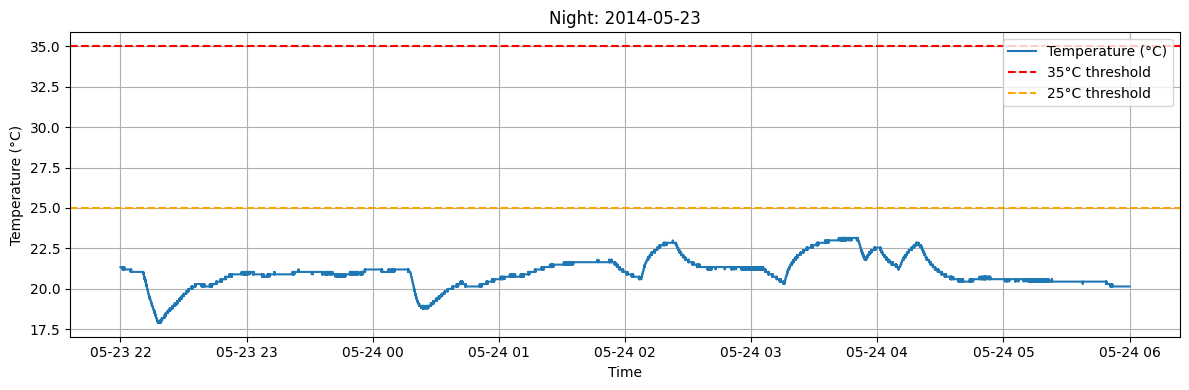

  Skipped 2014-05-23 (temperature below 25°C)
  Skipped 2014-05-24 (temperature below 25°C)
  Skipped 2014-05-25 (temperature below 25°C)
  Skipped 2014-05-26 (temperature below 25°C)
  Skipped 2014-05-27 (temperature below 25°C)
  Skipped 2014-05-28 (temperature below 25°C)
  Skipped 2014-05-29 (temperature below 25°C)

 Processed data saved to: data/preprocessed/preprocessed_data.h5


In [4]:
# Read accelerometer data with preprocessing options:
# - Apply a low-pass filter at 20Hz to remove noise
# - Calibrate gravity to standardize accelerometer readings
# - Detect non-wear periods (to filter out irrelevant data)
# - Resample the data to 30Hz for consistency

# Process each file
for file_idx, cwa_file in enumerate(cwa_files):
    print(f"\nProcessing file {file_idx+1}/{len(cwa_files)}: {cwa_file}")

    try:
        # Read and preprocess data
        data, info = actipy.read_device(
            cwa_file,
            lowpass_hz=20,
            calibrate_gravity=True,
            detect_nonwear=True,
            resample_hz=30
        )

        # Debugging
        #print("Data columns:", data.columns.tolist())
        #print("Info attributes:", dir(info))

        data.index = pd.to_datetime(data.index) # Ensure timestamps are datetime and set as index
        data = data.sort_index() # Ensure chronological order

        # Segment into nights
        night_segments = segment_by_night(data)
        # print(f"Total number of detected nights: {len(night_segments)}") # Debugging

        
        for night, df_night in night_segments.items():
            temp_data = data.loc[df_night['datetime'], 'temperature']
            time_data = df_night['datetime']

            plt.figure(figsize=(12, 4))
            plt.plot(time_data, temp_data, label='Temperature (°C)')
            plt.axhline(35, color='r', linestyle='--', label='35°C threshold')
            plt.axhline(25, color='orange', linestyle='--', label='25°C threshold')
            plt.xlabel("Time")
            plt.ylabel("Temperature (°C)")
            plt.title(f"Night: {night}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            break  # remove this if you want to see all nights

        # Save usable nights to HDF5
        with h5py.File(hdf5_filename, "a") as hf:
            for night_id, (night, df_night) in enumerate(night_segments.items()):
                temp_data = data.loc[df_night['datetime'], 'temperature']

                # Skip night if temperature below 25°C
                if (temp_data < 25).any():
                    print(f"  Skipped {night} (temperature below 25°C)")
                    continue

                grp_name = f"{os.path.basename(cwa_file).replace('.cwa','')}_{night}"
                if grp_name in hf:
                    print(f"  Skipped {grp_name} (already exists)")
                    continue

                grp = hf.create_group(grp_name)
                timestamps = (df_night['datetime'].astype(np.int64) // 10**9).values
                grp.create_dataset("timestamps", data=timestamps)
                grp.create_dataset("x", data=df_night['x'].values)
                grp.create_dataset("y", data=df_night['y'].values)
                grp.create_dataset("z", data=df_night['z'].values)
                grp.attrs["source_file"] = os.path.basename(cwa_file)

    except Exception as e:
        print(f" Error processing {cwa_file}: {e}")

print(f"\n Processed data saved to: {hdf5_filename}")